## Python import

In [21]:
!pip install -U segmentation-models

Requirement already up-to-date: segmentation-models in c:\users\user\anaconda3\lib\site-packages (1.0.1)


In [45]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

import efficientnet.tfkeras as efn 
from efficientnet.tfkeras import EfficientNetB3

In [34]:
print(tf.__version__,keras.__version__)

2.3.0 2.4.3


## Load Data

In [37]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

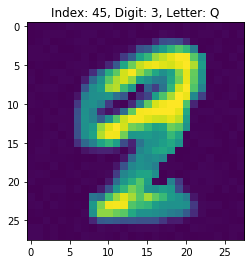

In [38]:
idx = 45
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## efficientnet에 넣어지게 수정

In [39]:
#1차원을 3차원으로 만들어주는 함수
def changeChannel(image):
    input_ = Input((28,28,1))
    conv2d = Conv2D(3, 1, use_bias=False,name="conv2d")
    out1 = conv2d(input_)
    out1.trainable = False
    model1=Model(input_, out1)
    print(model1.summary())
    model1.layers[1].set_weights([np.ones(([1, 1, 1, 3]))/3])
    
    res = model1.predict(image)
    return res

## Train model

In [40]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [64]:
x_train.shape

(2048, 28, 28, 1)

In [65]:
x_train_3=changeChannel(x_train)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 3)         3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
x_train_3.shape

(2048, 28, 28, 3)

In [76]:
x_train

array([[[[0.00392157],
         [0.00392157],
         [0.00392157],
         ...,
         [0.00784314],
         [0.        ],
         [0.01568627]],

        [[0.        ],
         [0.00392157],
         [0.01176471],
         ...,
         [0.01568627],
         [0.00392157],
         [0.01176471]],

        [[0.00784314],
         [0.        ],
         [0.01568627],
         ...,
         [0.01176471],
         [0.01176471],
         [0.01176471]],

        ...,

        [[0.00784314],
         [0.00392157],
         [0.00784314],
         ...,
         [0.01568627],
         [0.00392157],
         [0.        ]],

        [[0.01176471],
         [0.01176471],
         [0.01176471],
         ...,
         [0.01176471],
         [0.01176471],
         [0.        ]],

        [[0.01176471],
         [0.00784314],
         [0.00784314],
         ...,
         [0.01568627],
         [0.01176471],
         [0.01568627]]],


       [[[0.        ],
         [0.01568627],
         [0.  

In [77]:
x_train_3
# x_train과 비교했을 때 값이 달라지는군...

array([[[[0.00130719, 0.00130719, 0.00130719],
         [0.00130719, 0.00130719, 0.00130719],
         [0.00130719, 0.00130719, 0.00130719],
         ...,
         [0.00261438, 0.00261438, 0.00261438],
         [0.        , 0.        , 0.        ],
         [0.00522876, 0.00522876, 0.00522876]],

        [[0.        , 0.        , 0.        ],
         [0.00130719, 0.00130719, 0.00130719],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00522876, 0.00522876, 0.00522876],
         [0.00130719, 0.00130719, 0.00130719],
         [0.00392157, 0.00392157, 0.00392157]],

        [[0.00261438, 0.00261438, 0.00261438],
         [0.        , 0.        , 0.        ],
         [0.00522876, 0.00522876, 0.00522876],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],

        ...,

        [[0.00261438, 0.00261438, 0.00261438],
         [0.00130719, 0.00130719, 0.00130719]

In [72]:
#padding
#https://stackoverflow.com/questions/61309432/padding-mnist-images-from-28-28-1-to-32-32-1
x_train_32=np.pad(x_train_3,((0,0),(2,2),(2,2),(0,0)),'constant')

In [73]:
x_train_32.shape

(2048, 32, 32, 3)

In [78]:
x_train_32

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.00130719, 0.00130719, 0.00130719],
         ...,
         [0.00522876, 0.00522876, 0.00522876],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [ ]:
model = EfficientNetB3(weights='imagenet', input_shape = (32,32,3), include_top=False)

26517504/44107200 [=================>............] - ETA: 5:54

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1
   # brightness_range=[0.8,1.2] #이걸조절하니까 다 1로예측함 ㅠㅠ
)

model = create_cnn_model()

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(x_train, y_train, batch_size=16),
  epochs=200, 
  steps_per_epoch = x_train.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 1s 8ms/step - loss: 3.8202 - accuracy: 0.2334 - lr: 0.0010
Epoch 2/200
128/128 [==============================] - 1s 8ms/step - loss: 2.8257 - accuracy: 0.3374 - lr: 9.5000e-04
Epoch 3/200
128/128 [==============================] - 1s 8ms/step - loss: 2.5206 - accuracy: 0.4048 - lr: 9.0250e-04
Epoch 4/200
128/128 [==============================] - 1s 8ms/step - loss: 2.3187 - accuracy: 0.4443 - lr: 8.5737e-04
Epoch 5/200
128/128 [==============================] - 1s 8ms/step - loss: 2.2180 - accuracy: 0.4810 - lr: 8.1451e-04
Epoch 6/200
128/128 [==============================] - 1s 8ms/step - loss: 2.0682 - accuracy: 0.5151 - lr: 7.7378e-04
Epoch 7/200
128/128 [==============================] - 1s 8ms/step - loss: 1.9362 - accuracy: 0.5610 - lr: 7.3509e-04
Epoch 8/200
128/128 [==============================] - 1s 8ms/step - loss: 1.7413 - accuracy: 0.6294 - lr: 6.9834e-04
Epoch 9/200
128/128 [==============================] - 1s 7m

Epoch 70/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4934 - accuracy: 0.9414 - lr: 2.9035e-05
Epoch 71/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4856 - accuracy: 0.9468 - lr: 2.7584e-05
Epoch 72/200
128/128 [==============================] - 1s 7ms/step - loss: 0.5008 - accuracy: 0.9419 - lr: 2.6205e-05
Epoch 73/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4802 - accuracy: 0.9463 - lr: 2.4894e-05
Epoch 74/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4968 - accuracy: 0.9424 - lr: 2.3650e-05
Epoch 75/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4934 - accuracy: 0.9453 - lr: 2.2467e-05
Epoch 76/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4882 - accuracy: 0.9409 - lr: 2.1344e-05
Epoch 77/200
128/128 [==============================] - 1s 8ms/step - loss: 0.4865 - accuracy: 0.9473 - lr: 2.0277e-05
Epoch 78/200
128/128 [==========================

## Predict

In [22]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head(50)

,id,digit
0,2049,6
1,2050,5
2,2051,6
3,2052,8
4,2053,3
5,2054,8
6,2055,5
7,2056,3
8,2057,1
9,2058,4


In [15]:
submission.to_csv('epoch200_parm수정2.csv', index=False)